In [1]:
import os
import numpy as np

from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
import pydicom
import random
import matplotlib.pyplot as plt
import glob
import matplotlib.patches as patches

import cv2

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '5,6'                        
import tensorflow as tf
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
W0408 10:59:05.267633 33308 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0408 10:59:05.267633 33308 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0408 10:59:05.267633 33308 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0408 10:59:08.797454 33308 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [3]:
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage import morphology
from skimage.filters import threshold_otsu, threshold_local

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import random
import pandas as pd

plt.style.use("ggplot")



from tqdm import tqdm_notebook, tnrange
from itertools import chain
from sklearn.model_selection import train_test_split


In [4]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def get_unet(input_img, n_filters = 8, dropout = 0.2, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [5]:
def dice_coef(y_true, y_pred):
    from keras import backend as K
    smooth=1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def custom_loss(y_true, y_pred):
    from keras.losses import binary_crossentropy
    return 0.5*keras.losses.binary_crossentropy(y_true,y_pred)+0.5*dice_loss(y_true,y_pred)

In [6]:
im_height = 64
im_width = 64

input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=dice_loss, metrics=['accuracy', dice_coef])
model.summary()

W0408 10:59:10.701388 33308 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0408 10:59:10.709390 33308 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0408 10:59:10.713390 33308 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0408 10:59:10.752390 33308 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0408 10:59:10.8

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 16)   160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 64, 64, 16)   64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 64, 64, 16)   0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_poolin

In [7]:
model.load_weights('model_vessel-detection.h5')

W0408 10:59:12.573492 33308 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W0408 10:59:13.384717 33308 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



In [14]:
def detect4multipatches(img):
    
    steps = int((img.shape[0]-64)/4)+1
    
    M = np.empty((img.shape[0], img.shape[1], steps*steps))
    M[:] = np.NaN
    img_patch = np.zeros((steps*steps, 64, 64, 1))
    c = 0

    for i in range (0, steps):
        for j in range (0, steps):
            
            img_crop = img[4*i:4*i+64, 4*j:4*j+64]
            img_patch[c, ..., 0] = img_crop.copy()
            c += 1
            
    img_patch_pred = model.predict(img_patch, verbose=1)
    
    c = 0
    for i in range (0, steps):
        for j in range (0, steps):
            M[4*i:4*i+64, 4*j:4*j+64, c] = img_patch_pred[c, ..., 0]
            c += 1
            
    M_concord = np.nanmean(M, axis = 2)
    
    del M
            
    return M_concord

In [9]:
def path2array(dcm_path):
    arr_dcm = pydicom.read_file(dcm_path, force = True)
    arr_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
    arr = arr_dcm.pixel_array
    return arr

In [10]:
import SimpleITK as sitk

def correctBiasField(img_input):
    
    corrected = False
    img_output = np.zeros(img_input.shape)

    while not corrected:

        try:
            corrector = sitk.N4BiasFieldCorrectionImageFilter()
            inputImage = sitk.GetImageFromArray(img_input)
            inputImage = sitk.Cast(inputImage, sitk.sitkFloat32)
            output = corrector.Execute(inputImage)
            img_output = sitk.GetArrayFromImage(output)
            corrected = True
        except:
            print ('BFC failed')

    return img_output

In [11]:
from scipy.ndimage import zoom


def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

# Test set

In [16]:
sub_names_test = ['AMC012', 'AMC006', 'MUMC094', 'MUMC027', 'MUMC079', 'MUMC052', 'MUMC127', 'MUMC071', 'MUMC038',
                  'MUMC093', 'MUMC107', 'MUMC022', 'MUMC114', 'MUMC115', 'MUMC069', 'MUMC130', 'MUMC036', 'MUMC007', 
                  'MUMC059', 'MUMC080', 'UMCU036', 'UMCU025', 'UMCU008', 'UMCU034']

In [ ]:
ds_dir = 'Z:/Lisa/PARISK/PARISK-XNAT/plaque_converted_unempty slices/'
results_dir = 'I:/parisk_validation/validation_masks/test_set/'

for sub_name in sub_names_test:
    
    os.mkdir(results_dir+sub_name)
    sub_img_names = glob.glob(ds_dir+sub_name+'*/T1W_*.dcm')
    
    for sub_img_name in sub_img_names:
        
        img = path2array(sub_img_name)
        img_min = np.min(img)
        img_max = np.max(img)
        img_norm = np.copy((img - img_min)/(img_max - img_min)*255).astype(np.uint8)

        img_test = correctBiasField(img_norm[8:-8,8:-8])
        
        vessels_pred_multi = detect4multipatches(img_test)
        #vessels_pred_multi_th = vessels_pred_multi > 0.5
        #vessels_pred_multi_th_morph = morphology.remove_small_objects(vessels_pred_multi_th, 100, connectivity=3)
        
        np.save(results_dir + sub_name + '/' + sub_img_name.split(os.sep)[2][-10:-4] + '.npy', vessels_pred_multi)

12769/12769 [==============================] - 5s 394us/step
BFC failed
12769/12769 [==============================] - 5s 409us/step


# EMC

In [ ]:
ds_dir = 'I:/parisk_validation/validation_sets/EMC/'
results_dir = 'I:/parisk_validation/validation_masks/EMC/'

for folder_name in os.listdir(ds_dir):
    
    sub_name = folder_name[:6]
    
    os.mkdir(results_dir+sub_name)
    sub_img_names = glob.glob(ds_dir+sub_name+'*/T1W_*.dcm')
    
    for sub_img_name in sub_img_names:
        
        img = path2array(sub_img_name);
        img_min = np.min(img)
        img_max = np.max(img)
        img_norm = np.copy((img - img_min)/(img_max - img_min)*255).astype(np.uint8)
        img_norm_bfc = correctBiasField(img_norm)

        img_test = cv2.resize(img_norm_bfc.copy(), dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
        
        vessels_pred_multi = detect4multipatches(img_test)
        vessels_pred_multi_res = cv2.resize(vessels_pred_multi_th_morph.copy().astype(np.uint8), 
                                                     dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
        
        np.save(results_dir + sub_name + '/' + sub_img_name.split(os.sep)[2][-17:-11] + '.npy', vessels_pred_multi_res);

# Challenge data

In [ ]:
def readDicom(path):
    pi = os.path.basename(path).split('_')[1]
    dcm_size = len(glob.glob(path+'/*.dcm'))
    dcms = [path+'/E'+pi+'S101I%d.dcm'%dicom_slicei for dicom_slicei in range(1,dcm_size+1)]
    dcm_f = pydicom.read_file(dcms[0]).pixel_array
    dcm_size = max(dcm_f.shape)
    dcm_img = np.zeros((dcm_size,dcm_size,len(dcms)))
    for dcmi in range(len(dcms)):
        cdcm = pydicom.read_file(dcms[dcmi]).pixel_array
        dcm_img[dcm_size//2-cdcm.shape[0]//2:dcm_size//2+cdcm.shape[0]//2,
                dcm_size//2-cdcm.shape[1]//2:dcm_size//2+cdcm.shape[1]//2,dcmi] = cdcm
    return dcm_img

In [ ]:
cdir = "C:/Users/e.lavrova/Desktop/careIIChallenge/careIIChallenge/"
preds_dir = "C:/Users/e.lavrova/Desktop/careIIChallenge/masks/pred/"
gt_dir = "C:/Users/e.lavrova/Desktop/careIIChallenge/masks/gt/"

In [93]:
for casei in os.listdir(cdir)[:2]:
    if casei[0]=='0':
        
        #os.mkdir(preds_dir + casei)
        #os.mkdir(gt_dir + casei)
        
        pi = casei.split('_')[1]
        dcm_img = readDicom(cdir+'/'+casei)
        bin_mask = np.load(cdir+'/'+casei+'/mask.npy')
        dcm_img_crop = dcm_img[104:-104,104:-104,:]
        bin_mask_crop = bin_mask[104:-104,104:-104,:]
        
        for z in range (0, dcm_img.shape[2]):
            
            if np.sum(bin_mask_crop[..., z])>0:
                
                img_test = dcm_img_crop[..., z]
                img_min = np.min(img_test)
                img_max = np.max(img_test)
                img_norm = np.copy((img_test - img_min)/(img_max - img_min)*255).astype(np.uint8)
                
                break
                
                #vessels_pred_multi = detect4multipatches(img_norm)
                #vessels_pred_multi_th = vessels_pred_multi > 0.5
                #vessels_pred_multi_th_morph = morphology.remove_small_objects(vessels_pred_multi_th, 100, connectivity=3)
        
                #np.save(preds_dir + casei + '/' + str(z).zfill(4) + '.npy', vessels_pred_multi_th_morph)
                #np.save(gt_dir + casei + '/' + str(z).zfill(4) + '.npy', bin_mask_crop[..., z])
                

In [94]:
mask_simple = detect4multipatches(img_norm)
mask_simple_processed = morphology.remove_small_objects(mask_simple>0.5, 100, connectivity=3)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


12769/12769 [==============================] - 6s 470us/step


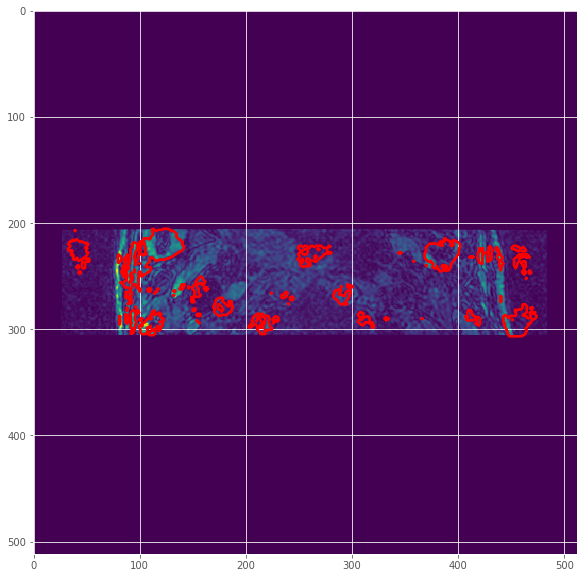

In [97]:
plt.figure(figsize=(10, 10))
plt.imshow(img_norm)
plt.contour(mask_simple>0.2, colors='r')
plt.show()

In [59]:
img_zoomed = clipped_zoom(img_norm, 0.347222/0.303030)

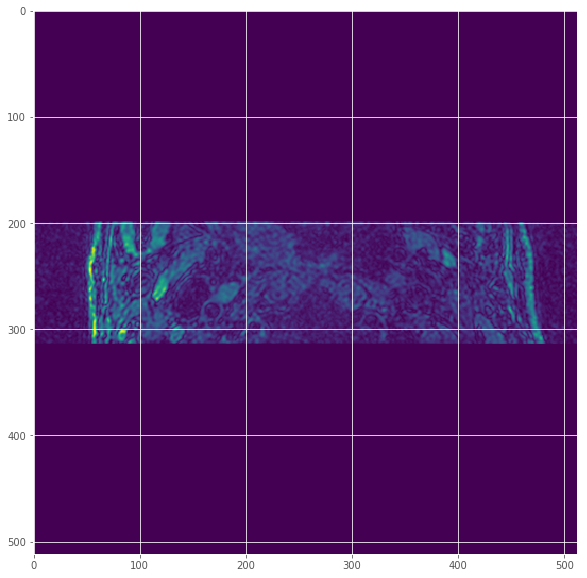

In [60]:
plt.figure(figsize=(10, 10))
plt.imshow(img_zoomed)
plt.show()

In [61]:
mask_zoomed = detect4multipatches(img_zoomed)
mask_zoomed_processed = morphology.remove_small_objects(mask_zoomed>0.5, 100, connectivity=3)

1/1 [==============================] - 0s 8ms/step


C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


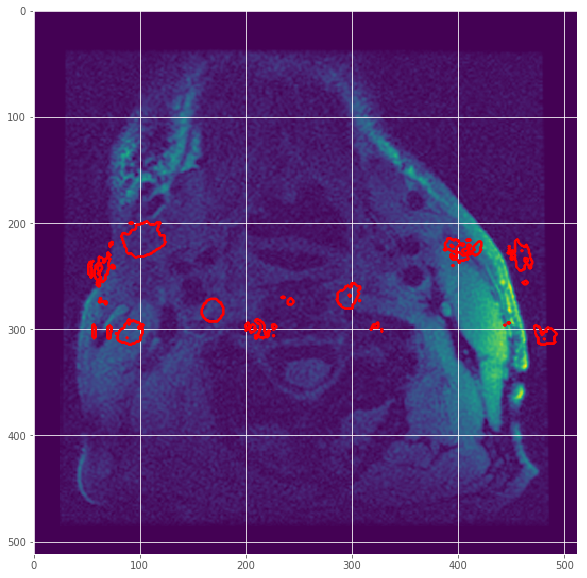

In [98]:
plt.figure(figsize=(10, 10))
plt.imshow(img_zoomed)
plt.contour(mask_zoomed>0.25, colors='r')
plt.show()

In [68]:
img_zoomed_bfc = correctBiasField(img_zoomed)

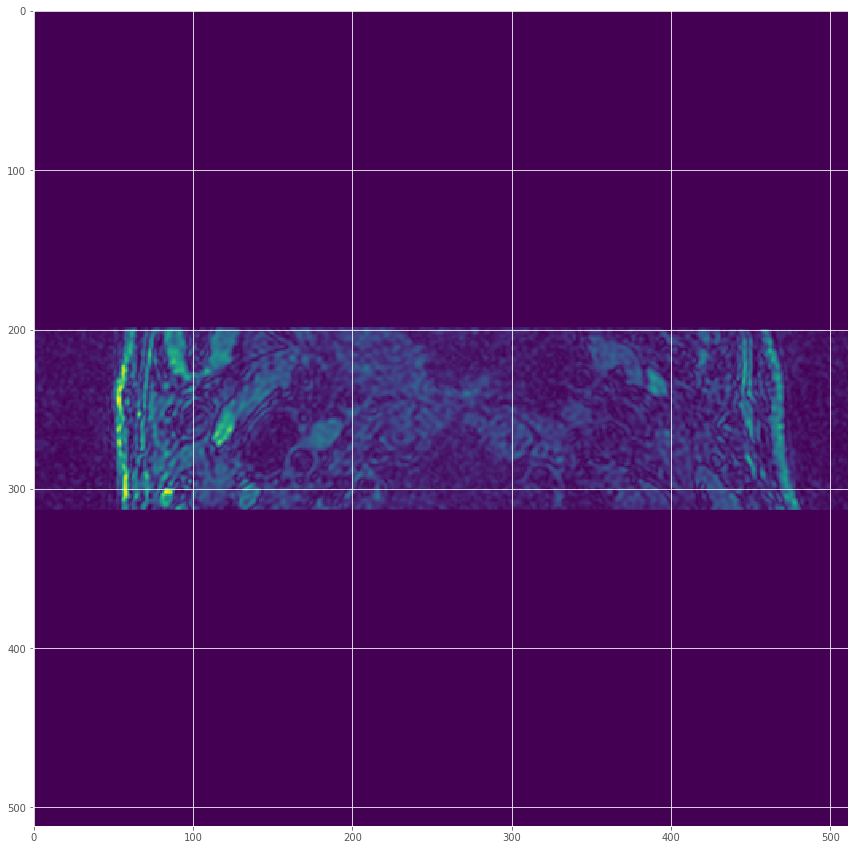

In [69]:
plt.figure(figsize=(15, 15))
plt.imshow(img_zoomed_bfc)
plt.show()

In [70]:
mask_zoomed_bfc = detect4multipatches(img_zoomed_bfc)
mask_zoomed_bfc_processed = morphology.remove_small_objects(mask_zoomed_bfc>0.5, 100, connectivity=3)

1/1 [==============================] - 0s 7ms/step


C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


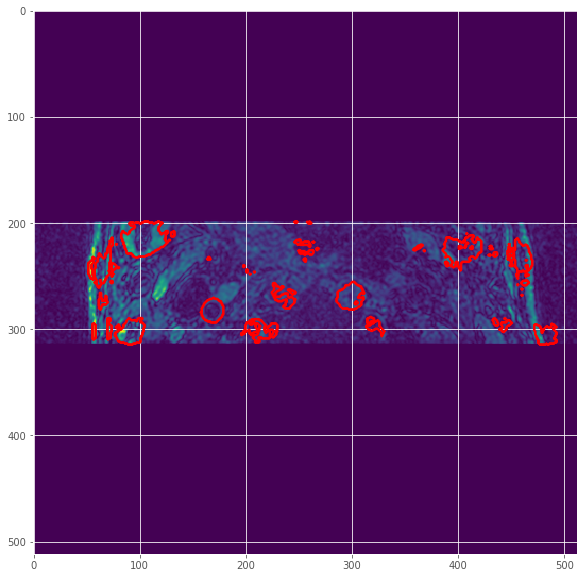

In [72]:
plt.figure(figsize=(10, 10))
plt.imshow(img_zoomed_bfc)
plt.contour(mask_zoomed_bfc>0.2, colors='r')
plt.show()

In [73]:
from skimage import exposure
from skimage import img_as_float

In [74]:
# Contrast stretching
p2, p98 = np.percentile(img_zoomed_bfc, (2, 98))
img_rescale = exposure.rescale_intensity(img_zoomed_bfc, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img_zoomed_bfc)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img_zoomed_bfc/255, clip_limit=0.005)

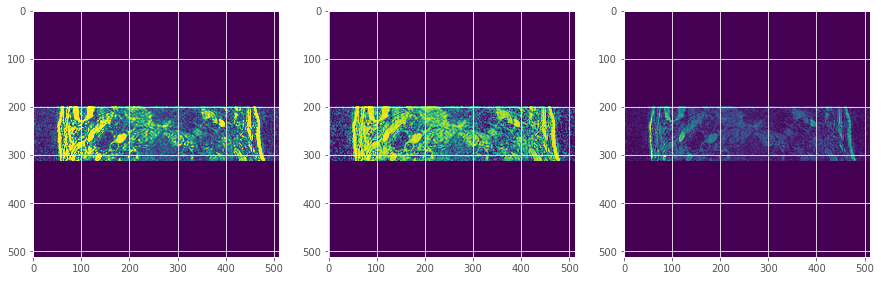

In [75]:
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(img_rescale)
plt.subplot(132)
plt.imshow(img_eq)
plt.subplot(133)
plt.imshow(img_adapteq)
plt.show()

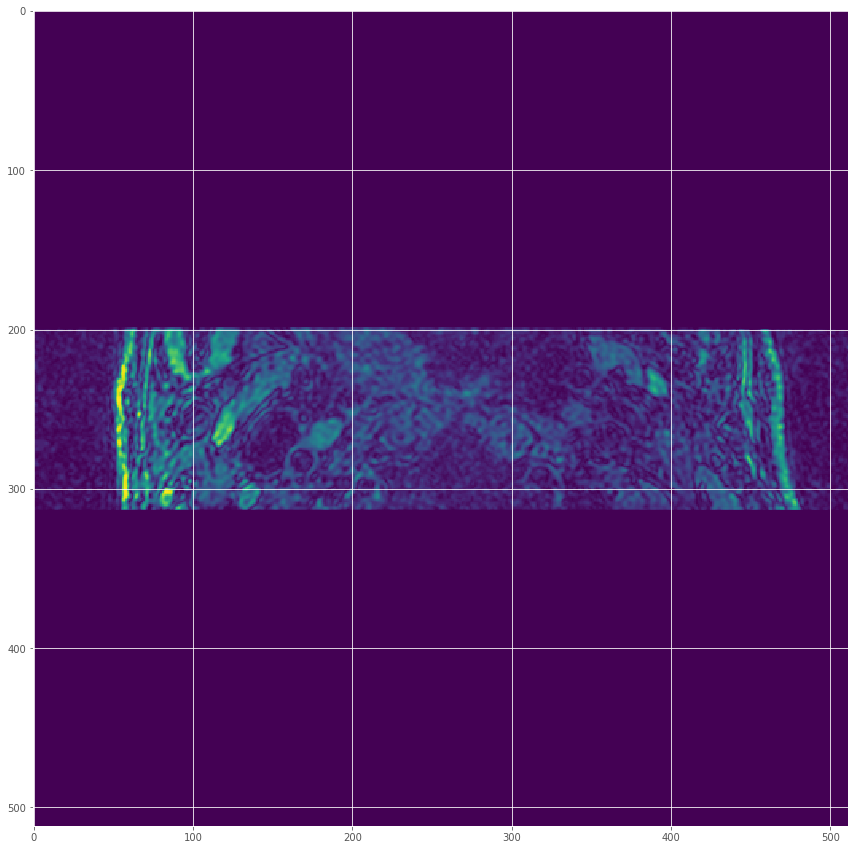

In [76]:
plt.figure(figsize=(15, 15))
plt.imshow((255*img_adapteq).astype(np.uint8))
plt.show()

In [77]:
img_zoomed_bfc_eq = (255*img_adapteq).astype(np.uint8)

In [78]:
mask_zoomed_bfc_eq = detect4multipatches(img_zoomed_bfc_eq)
mask_zoomed_bfc_eq_processed = morphology.remove_small_objects(mask_zoomed_bfc_eq>0.5, 100, connectivity=3)

1/1 [==============================] - 0s 7ms/step


C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


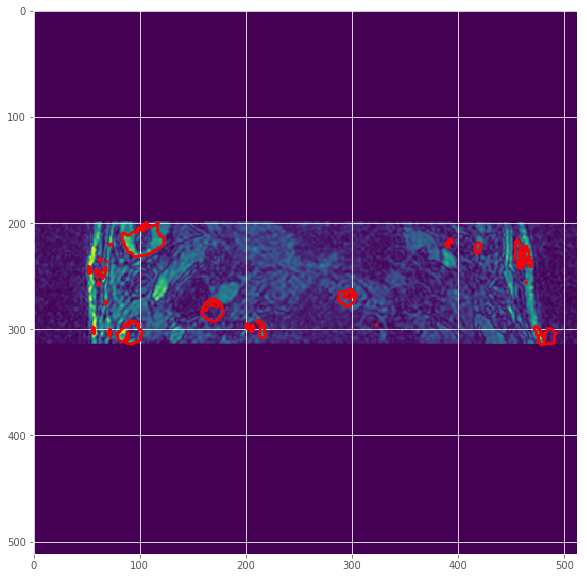

In [79]:
plt.figure(figsize=(10, 10))
plt.imshow(img_zoomed_bfc_eq)
plt.contour(mask_zoomed_bfc_eq>0.3, colors='r')
plt.show()

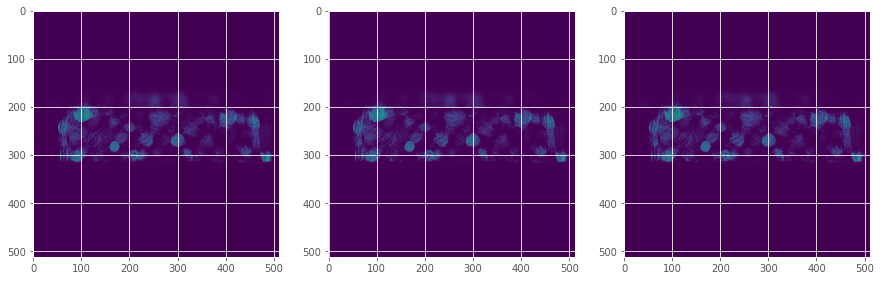

In [80]:
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(mask_zoomed, vmin=0, vmax=1)
plt.subplot(132)
plt.imshow(mask_zoomed_bfc, vmin=0, vmax=1)
plt.subplot(133)
plt.imshow(mask_zoomed_bfc_eq, vmin=0, vmax=1)
plt.show()

In [81]:
img = path2array(r"I:\parisk_validation\validation_sets\EMC\EMC005\T1w_SER_0014_sl0009_ph0001.dcm")

img_min = np.min(img)
img_max = np.max(img)

img_norm = ((img.copy()-img_min)/(img_max-img_min)*255).astype(np.uint8)

img_test = cv2.resize(img_norm.copy(), dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

In [82]:
img_zoomed = clipped_zoom(img_test, 0.546900/2/0.303030)

In [83]:
img_bfc = correctBiasField(img_zoomed)

In [84]:
img_adapteq = (exposure.equalize_adapthist(img_bfc/255, clip_limit=0.0075)*255).astype(np.uint8)

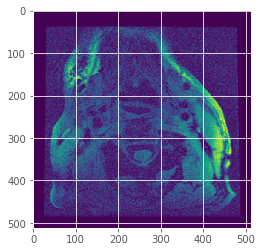

In [85]:
plt.imshow(img_adapteq)
plt.show()

In [86]:
mask = detect4multipatches(img_adapteq)

1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 0us/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


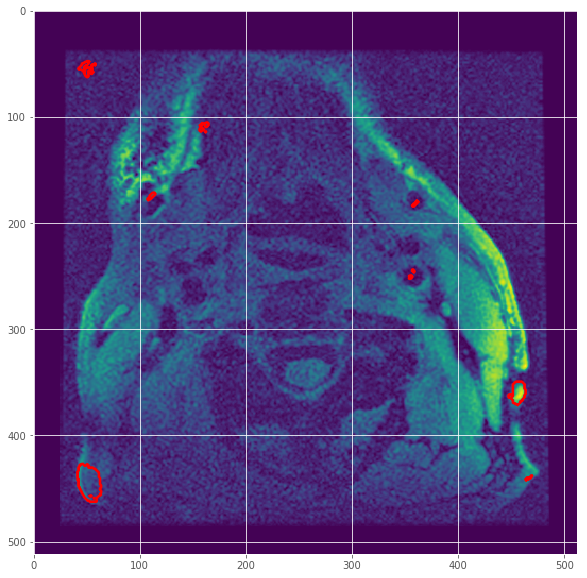

In [89]:
plt.figure(figsize=(10, 10))
plt.imshow(img_adapteq)
plt.contour(mask>0.5, colors='r')
plt.show()